## Gaussian beams

for a gaussian beam the waist is defined as follow

$$ w(z) = w_0 \sqrt{1+\left( \frac{\lambda z}{\pi w_0^2} \right)^2} = w_0 \sqrt{1+\left( \frac{z}{z_R} \right)^2} $$

while the rayleigh range can be expressed as:

$$ z_R = \frac{\pi w_0^2}{\lambda} $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_rayleigh_range(w0, wavelenght):
    return np.pi*w0**2/wavelenght

def get_wz(z, w0, wavelenght):
    return w0*np.sqrt(1+(z/get_rayleigh_range(w0, wavelenght))**2)

def intensity_profile_z(z, x, w0, wavelenght):
    return np.exp(-x**2/(2*get_wz(z, w0, wavelenght)**2))/(np.sqrt(2*np.pi*get_wz(z, w0, wavelenght)**2))

def inverse_intensity_profile_z(z, I, w0, wavelenght):
    return get_wz(z, w0, wavelenght)*np.sqrt(2*np.log(1/(I*np.sqrt(2*np.pi*get_wz(z, w0, wavelenght)**2))))

In [3]:
waist_0 = 5 # [um]
wavelenght = 840 * 10**-3 # [um]

z_R = get_rayleigh_range(waist_0, wavelenght)

zs = np.linspace(-2*z_R, 2*z_R, 10000)
wzs = get_wz(zs, waist_0, wavelenght)

x_fixedIs = []
for x in np.linspace(0, waist_0, 10):
    I0 = intensity_profile_z(0, x, waist_0, wavelenght)
    x_fixedIs.append(inverse_intensity_profile_z(zs, I0, waist_0, wavelenght))

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_1756/3895778566.py:15: RuntimeWarning: invalid value encountered in sqrt
  return get_wz(z, w0, wavelenght)*np.sqrt(2*np.log(1/(I*np.sqrt(2*np.pi*get_wz(z, w0, wavelenght)**2))))


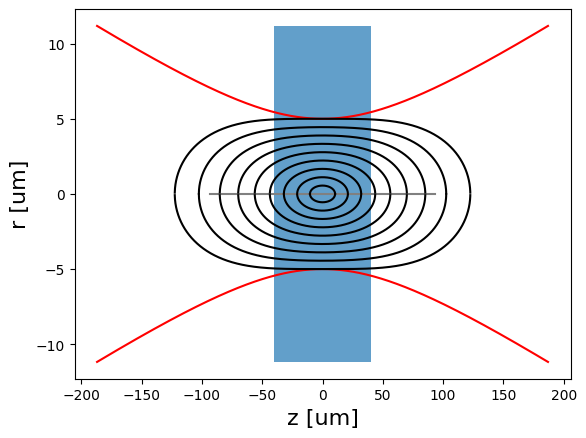

In [4]:
M = max(wzs)
plt.fill_between([-40, 40],[M, M],[-M, -M], alpha =0.7)

plt.plot(zs, wzs, c="r")
plt.plot(zs, -wzs, c="r")
plt.plot([-z_R,z_R],[0,0], c="gray")
for x_fixedI in x_fixedIs:
    plt.plot(zs, x_fixedI, c="black")
    plt.plot(zs, -x_fixedI, c="black")

plt.xlabel("z [um]",fontsize=16)
plt.ylabel("r [um]",fontsize=16)

plt.show()

## trap depth

the

$$ U_{dip}(z, r) = \frac{3 \pi c^2}{2 \omega_0^3} \frac{\Gamma}{\Delta} I(z, r) $$

$$ I(z, r) = \frac{2P}{\pi w(z)^2} e^{\frac{-2 r^2}{w(z)^2}} $$

so

$$ U_{dip}(z, r) =  \frac{3 \pi c^2}{2 \omega_0^3} \frac{\Gamma}{\Delta} \frac{2P}{\pi w(z)^2} e^{\frac{-2 r^2}{w(z)^2}} = \frac{3 c^2  P}{\omega_0^3 w(z)^2 }  \frac{\Gamma}{\Delta}  e^{-\frac{2 r^2}{w(z)^2} } $$

where 

$$ \Gamma = \frac{e^2 \omega_0^2}{6 \pi \epsilon_0 m_e c^3} $$

In [5]:
import scipy.constants as scc

class dipolar_trap:
    def __init__(self, power, waist_0, Temperature=1e-5) -> None:
        self.waist_0 = waist_0
        self.power = power
        self.rubidium_mass = 1.41810133E-25 # kg
        self.Delta = -2*np.pi*27e12
        self.T = Temperature # [K]
        self.omega_0 = 2*np.pi*377e12
        self.Gamma = scc.e**2*self.omega_0**2/(6*np.pi*scc.epsilon_0*scc.m_e*scc.c**3)
        self.alpha = 3*scc.c**2 * self.Gamma * self.power / (self.omega_0**3 * abs(self.Delta))
        self.wavelenght = 840*scc.nano
        self.z_R = np.pi*waist_0**2/self.wavelenght
        self.var_r_0 = scc.Boltzmann * self.T * self.waist_0**4 / (4*self.alpha)
        self.var_z_0 = self.var_r_0 * np.pi**2 * self.waist_0**2 / self.wavelenght**2
        pass

    def get_wz(self, z):
        return self.waist_0*np.sqrt(1+(z/self.z_R)**2)

    def var_r(self, t):
        """ 
        returns the variance of the density distribution in a time t.
        """
        return self.var_r_0 + (scc.Boltzmann*self.T/self.rubidium_mass) * t**2
    
    def var_z(self, t):
        """ 
        returns the variance of the density distribution in a time t.
        """
        return self.var_z_0 + (scc.Boltzmann*self.T/self.rubidium_mass) * t**2

    def I(self, z, r):
        return 2*self.power*np.exp(-2*r**2/(self.get_wz(z)**2))/(np.pi*self.get_wz(z)**2)

    def get_inverse_I(self, z, I_0):
        return self.get_wz(z)*np.sqrt(0.5*np.log(2*self.power/(np.pi*self.get_wz(z)**2*I_0)))

    def U_dip(self, z, r):
        """
        returns the potential in mK.
        """
        return (3*np.pi*scc.c**2)/(2*self.omega_0**3) * (self.Gamma/self.Delta) * self.I(z, r) / scc.Boltzmann * 10**3
    
    def get_inverse_U_dip(self, z, U_0):
        """
        returns the r position of a point (z, U)
        """
        return self.get_wz(z)*np.sqrt(0.5*np.log(3*scc.c**2*self.power*self.Gamma/(self.omega_0**3 * self.get_wz(z)**2 * self.Delta * U_0)))
    
    def local_density(self, z, r, t=0):
        return np.e**(- z**2/(2*self.var_z(t)) - r**2 / (2*self.var_r(t)))

    def get_inverse_loc_dens(self, z, local_density_0, t=0):
        return np.sqrt(-(np.log(local_density_0)+z**2/(2*self.var_z(t)))*2*self.var_r(t))


In [6]:
power = 100e-3
waist_0 = 5e-6

my_dip = dipolar_trap(power = power, waist_0=waist_0)

my_dip.U_dip(0.000001,0.000001) * scc.Boltzmann / 10**3, my_dip.I(0.000001,0.000001)

(-1.5523454429714532e-26, 2350449119.9473195)

In [7]:
my_dip.get_inverse_U_dip(0.000001,-1.5523454429714532e-26), my_dip.get_inverse_I(0.000001,2350449119.9473195)

(9.999999999999978e-07, 1.0000000000000004e-06)

In [8]:
T = 100e-6
T*10**3

0.1

In [9]:
zs = np.linspace(1e-6, 1e-3, 100)
rs = np.linspace(1e-6, 6.4e-6, 10)
Us = []

r_fixedIs = []
r_fixedUs = []

for r in rs:
    I0 = my_dip.I(zs[0], r)
    U0 = my_dip.U_dip(0,r) * scc.Boltzmann / 10**3
    Us.append(U0)
    
    Is_aus = []
    Us_aus = []
    for z in zs:
        Is_aus.append(my_dip.get_inverse_I(z, I0))
        Us_aus.append(my_dip.get_inverse_U_dip(z, U0))
    r_fixedIs.append(np.array(Is_aus))
    r_fixedUs.append(np.array(Us_aus))

U0 = -scc.Boltzmann * T
print(U0)
Us_T = []
for z in zs:
    Us_T.append(my_dip.get_inverse_U_dip(z, U0))

-1.380649e-27


/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_1756/4229175337.py:38: RuntimeWarning: invalid value encountered in sqrt
  return self.get_wz(z)*np.sqrt(0.5*np.log(2*self.power/(np.pi*self.get_wz(z)**2*I_0)))
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_1756/4229175337.py:50: RuntimeWarning: invalid value encountered in sqrt
  return self.get_wz(z)*np.sqrt(0.5*np.log(3*scc.c**2*self.power*self.Gamma/(self.omega_0**3 * self.get_wz(z)**2 * self.Delta * U_0)))


In [10]:
my_dip.U_dip(zs[0],rs)

array([-1.12435923, -0.99245617, -0.82699919, -0.65055846, -0.48312006,
       -0.33869697, -0.22415842, -0.14005103, -0.08260475, -0.04599507])

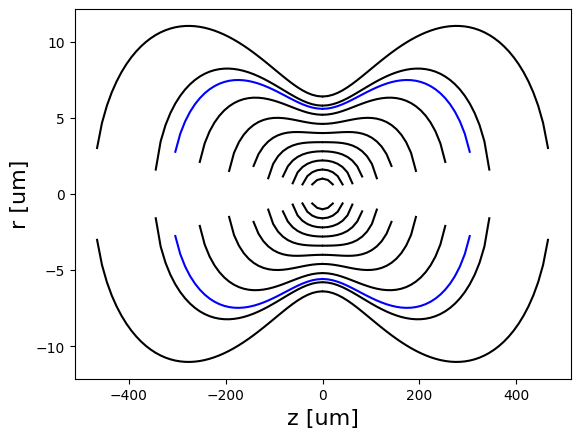

In [11]:

for r_fixedU in r_fixedUs:
    plt.plot(zs*1e6, r_fixedU*1e6, c="black")
    plt.plot(zs*1e6, -r_fixedU*1e6, c="black")
    plt.plot(-zs*1e6, r_fixedU*1e6, c="black")
    plt.plot(-zs*1e6, -r_fixedU*1e6, c="black")
plt.plot(zs*1e6, np.array(Us_T)*1e6, c="blue")
plt.plot(zs*1e6, -np.array(Us_T)*1e6, c="blue")
plt.plot(-zs*1e6, np.array(Us_T)*1e6, c="blue")
plt.plot(-zs*1e6, -np.array(Us_T)*1e6, c="blue")

plt.xlabel("z [um]",fontsize=16)
plt.ylabel("r [um]",fontsize=16)

plt.show()

In [12]:
n = 1000
#zs = np.array(list(np.linspace(5e-6, 5e-4, n))+list(np.linspace(-5e-4, -5e-6, n)))
zs = np.linspace(-1e-3, 1e-3, n)
rs = np.linspace(-2e-4, 2e-4, n)
#rs = np.array(list(np.linspace(-1e-5, -1e-6, n))+list(np.linspace(1e-6, 1e-5, n)))

X, Y = np.meshgrid(rs, zs)
Z = []

for i in range(len(X)):
    z = []
    for j in range(len(X[0])):
        U = -my_dip.U_dip(Y[i,j], X[i,j])
        z.append(U)
    Z.append(z)

In [13]:
np.logspace(0, 1, 10, base=np.e)

array([1.        , 1.11751907, 1.24884887, 1.39561243, 1.5596235 ,
       1.742909  , 1.94773404, 2.17662993, 2.43242545, 2.71828183])

1.218131989059936


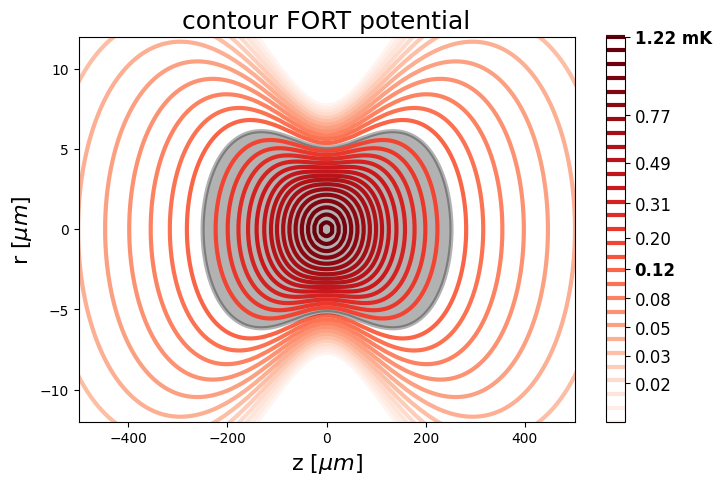

In [14]:

fig, ax = plt.subplots(figsize=(8, 5))
n_lin = 9
n_log = 20
levels = -my_dip.U_dip(np.array(list(np.linspace(0, 1e-4, n_lin)) + list(np.logspace(-4+np.log10(1.12), -3, n_log))), 0)
CS = ax.contour(Y*1e6, X*1e6, Z, levels[::-1], cmap=cm.Reds, linewidths=3)#(, Z, 10)

CB = fig.colorbar(CS, shrink=1)

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

CB.mappable.set_norm(LogNorm())
lables = np.logspace(np.log(0.02), np.log(-my_dip.U_dip(0,0)), 10, base=np.e)
print(lables[-1])
CB.set_ticks(lables)
labels2 = ["%.2f"%label for label in lables[:-1]]
labels2.append("%.2f mK"%lables[-1])

CB.set_ticklabels(labels2, fontsize=12)

labels = CB.ax.get_yticklabels()
labels[-1].set_weight('bold')
labels[4].set_weight('bold')

CS.collections[12].set_color("black")
CS.collections[12].set_alpha(0.3)

#CB.mappable.set_norm(SymLogNorm(linthresh=0.01, linscale=0.03, vmin=-1, vmax=10))
#ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('contour FORT potential', fontsize=18)

#ax.clabel(CS, levels[1::2],  # label every second level
#          inline=True, fmt='%.2f', fontsize=10)
#im = ax.imshow(Y*1e6, X*1e6, Z, interpolation='bilinear', origin="lower",
#               cmap=cm.gray)#, extent=(-30, 30, -2, 2))

ax.set_xlabel(r"z [$\mu m$]", fontsize=16)
ax.set_ylabel(r"r [$\mu m$]", fontsize=16)

ax.set_xlim([-500,500])
ax.set_ylim([-12,12])

plt.savefig('countour_udip.png', dpi=300)

plt.show()


Calculus of the blue surface
$$
A = \int_0^{z_{max}} 2 \pi r(z) dz
$$
where $U_{dip} = U_0$ is fixed and
$$
r(z) = w(z) \sqrt{\frac{1}{2} \ln \bigg(\frac{3 c^2 P \Gamma}{\omega_0^3 w(z)^2 \Delta}\frac{1}{ U_0}} \bigg)
$$

In [15]:
print("\033[1m1.22\033[0m")

1.22


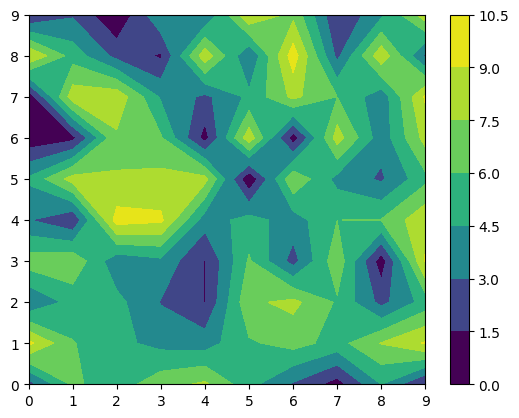

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# generiamo un'immagine di esempio
data = np.random.rand(10, 10) * 10
plt.contourf(data)

# aggiungiamo una colorbar alla figura
cbar = plt.colorbar()

# impostiamo la scala logaritmica sulla colorbar
cbar.mappable.set_norm(LogNorm())

plt.show()

In [17]:
from scipy.integrate import quad

U0 = -scc.Boltzmann * T
def fun(x):
    return my_dip.get_inverse_U_dip(x, U0)

A = 2*quad(fun, 0, 310e-6)[0]

Plot the density coutour

In [18]:
zs = np.linspace(1e-6, 1e-3, 10000)
rs = np.linspace(1e-6, 6.4e-6, 10)

r_fixed_lds = []

for r in rs:
    d0 = my_dip.local_density(zs[0], r)
    ld_aus = []
    for z in zs:
        ld_aus.append(my_dip.get_inverse_loc_dens(z, d0))
    r_fixed_lds.append(np.array(ld_aus))

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_1756/4229175337.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-(np.log(local_density_0)+z**2/(2*self.var_z(t)))*2*self.var_r(t))


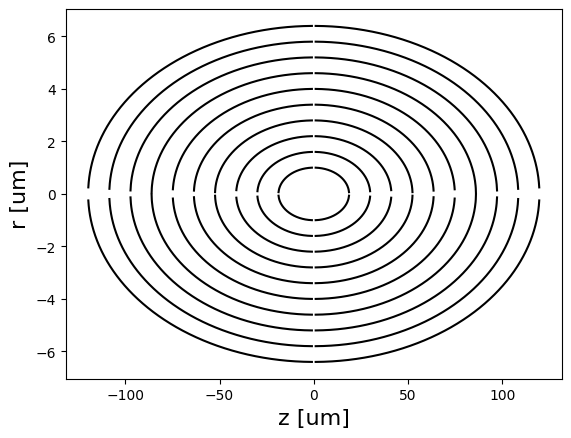

In [19]:
for r_fixed_ld in r_fixed_lds:
    plt.plot(zs*1e6, r_fixed_ld*1e6, c="black")
    plt.plot(zs*1e6, -r_fixed_ld*1e6, c="black")
    plt.plot(-zs*1e6, r_fixed_ld*1e6, c="black")
    plt.plot(-zs*1e6, -r_fixed_ld*1e6, c="black")
#plt.plot(zs*1e6, np.array(Us_T)*1e6, c="blue")
#plt.plot(zs*1e6, -np.array(Us_T)*1e6, c="blue")
#plt.plot(-zs*1e6, np.array(Us_T)*1e6, c="blue")
#plt.plot(-zs*1e6, -np.array(Us_T)*1e6, c="blue")

plt.xlabel("z [um]",fontsize=16)
plt.ylabel("r [um]",fontsize=16)

plt.show()

# Volume law of the number of atoms

In [20]:
# data

Ps = [ 25. , 35. , 48. , 60. , 70. , 84. , 91. , 101. , 110. , 121., 128.] 
Ns = np.array([  1. ,   3.7 , 15.5 , 18. ,  34.6 , 65.4 , 87.1, 140.8 ,127.7, 184.7, 173.9] )
dNs = [ 1.26491106 , 1.9  ,       4.29534632,  4.14728827,  7.36478106,  8.53463532,
  8.0925892 , 11.93984925, 15.52449677, 14.64274564, 12.8097619 ]


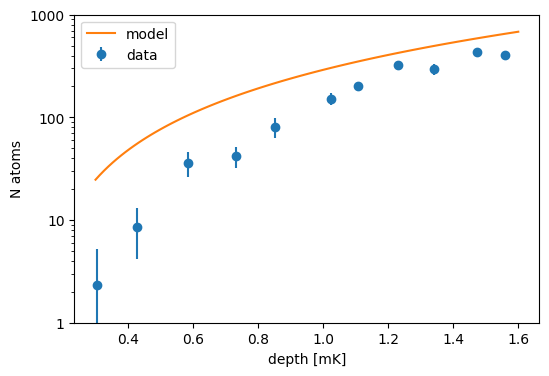

In [21]:
from scipy.integrate import quad
from scipy.optimize import curve_fit

U_ms = np.linspace(0.3,1.6,100)*scc.milli

waist_0 = 5 * scc.micron # [um]
wavelenght = 840 * scc.nano # [nm]
omega_0 = 2*np.pi*377e12
Gamma = scc.e**2*omega_0**2/(6*np.pi*scc.epsilon_0*scc.m_e*scc.c**3)
Delta = -2*np.pi*27e12
T = 120 * scc.micro
density = 10**9 * scc.centi**(-3)

z_R = get_rayleigh_range(waist_0, wavelenght)

def get_wz(z):
        return waist_0*np.sqrt(1+(z/z_R)**2)

def I(z, r, P):
        return 2*P*np.exp(-2*r**2/(get_wz(z)**2))/(np.pi*get_wz(z)**2)

def U_dip(z, r, P):
        """
        returns the potential in mK.
        """
        return (3*np.pi*scc.c**2)/(2*omega_0**3) * (Gamma/Delta) * I(z, r, P) / scc.Boltzmann

def volume_cilinder(U_m, T):
        #U_m = U_dip(0, 0, P)
        return np.pi*waist_0**2*z_R*(0.5)*np.log(U_m/T)*np.sqrt(U_m/T-1)

def volume_exact(U_m, T):
        #U_m = U_dip(0, 0, P)
        z_0 = z_R*np.sqrt((U_m/T)-1)

        def integrand(z):
                return 2*np.pi*get_wz(z)**2*np.log(U_m/T)

        result = quad(integrand, 0, z_0)
        return result[0]

def area_exact(U_m, T):
        #U_m = U_dip(0, 0, P)
        z_0 = z_R*np.sqrt((U_m/T)-1)

        def integrand(z):
                return 4*np.pi*get_wz(z)*np.sqrt(np.log(U_m/T))

        result = quad(integrand, 0, z_0)
        return result[0]


vol_cil = volume_cilinder(U_ms, T) 
vol_exa = np.array([volume_exact(U_m, T) for U_m in U_ms]) 

plt.figure(figsize=(6,4))
"""
plt.subplot(2,1,1)
plt.plot(U_ms/scc.milli,vol_cil/scc.centi**3, label="cilinder")
plt.plot(U_ms/scc.milli,vol_exa/scc.centi**3, label="exact")
plt.ylabel(r"Volume [cm$^{3}$]")
plt.xlabel("depth [mK]")
plt.yscale("log")
plt.legend()

N_cil = vol_cil * density
N_exa = vol_exa * density

plt.subplot(2,1,2)
"""
N_cil = vol_cil * density
N_exa = vol_exa * density

# plot data 
Us_  = np.array(list([-U_dip(0, 0, P) for P in Ps]))
plt.errorbar(Us_, Ns/0.43, np.array(dNs)/0.43, marker="o", linestyle="", label="data")

#plt.plot(U_ms/scc.milli, N_cil, label="cilinder")
plt.plot(U_ms/scc.milli, N_exa, label="model")

# fit
def N_atoms_(x, dens_):
        try:
                return volume_exact(x, T) * dens_ * scc.centi**(-3)
        except:
                return np.array([volume_exact(x_, T) * dens_ * scc.centi**(-3) for x_ in x])

res, _ = curve_fit(N_atoms_, Us_, Ns, sigma=dNs, p0=[density])
N_fit = np.array([N_atoms_(U_m, *res) for U_m in U_ms])

#plt.plot(U_ms/scc.milli, N_fit, label="fit")

plt.ylabel("N atoms")
plt.xlabel("depth [mK]")
plt.yscale("log")
#plt.ylim([1,10**3])
plt.legend()
plt.yticks([1,10,100,1000],labels=["1","10","100","1000"])
plt.savefig('fit_number_of_atoms.png', dpi=300)
plt.show()

In [22]:
density*area_exact(1e-3, 120e-6)*0.1/4 * 0.3 * 1e-5

3.0600476451626037

In [23]:
U_dip(0,0,136)

-1.6566595051215134

In [24]:
1-np.e**(-0.15*1.6)

0.21337213893344653

In [25]:
volume_exact(1.6*1e-3, 120*1e-6)

6.82858295481294e-13

In [31]:
scc.speed_of_light  * scc.h / 840e-9 / scc.electron_volt

1.4760023623000031